<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex04/luiz_gontijo/Aula_4_Exerc%C3%ADcio_Template_Luiz_Fernando_Gontijo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aluno: Luiz Fernando da Costa Gontijo RA230677

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Sobre a execução do trabalho
Alguns pontos acerca da programação orientada a objeto, com a criação de classes e métodos dentro delas ainda não estavam claros para mim. Com isso, recorri à orientação de alguns colegas de classe. O trabalho apresentado pelo aluno Leonardo Augusto da Silva Pacheco me ajudou bastante na execução da proposta. 

Além disso, a visualização das classificaçõs proposta pelo último exercício do notebook foi auxiliada pelo aluno Mateus Oliveira da Silva.

Agradeço a disponibilidade dos notebooks e reafirmo o meu comprometimento com o aprendizado contínuo das propostas da disciplina. 

## Importação das bibliotecas

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [33]:
# rodar essas seeds sempre que for rodar modelo de novo

random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [34]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [35]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [36]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [37]:
from math import ceil

In [38]:
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

# deve fazer:
# separar dados em batchs
# realizar ou não shuffle
# poder iterar nos batchs

class DataLoader:
  def __init__(self, dataset, batch_size, shuffle=True):
    # batch size
    self.batch_size = batch_size

    # shuffle or not
    if shuffle:
      self.dataset = dataset[torch.randperm(len(dataset))]
    else:
      self.dataset = dataset

  def __len__(self):
    self.batch_number = ceil(len(self.dataset)/self.batch_size)
    return self.batch_number

  def __iter__(self):
    self.batch_index = 0
    return self

  def __next__(self):
    batch_size = self.batch_size
    #print(batch_size)

    if self.batch_index >= len(self.dataset):
      raise StopIteration

    # pegar cada batch
    for batch_index in range(batch_size):
      # print(batch)
      data, target = self.dataset[batch_index + self.batch_index]

      if batch_index == 0:
        batch_data = data
        batch_targets = torch.tensor([target])
      else:
        batch_data = torch.cat((batch_data, data))
        batch_targets = torch.cat((batch_targets, torch.tensor([target])))
      # incrementar ao final do loop para ir para o próximo número
    self.batch_index += batch_size

    return batch_data, batch_targets

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [39]:
print('Número de minibatches de treinamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de treinamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [40]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

# deve fazer:
# receber dados de tamanho da rede
# realizar produto escalar entre vetores de pesos e de entrada e somar com o bias
# entregar dados de pesos e bias

class Model:
    def __init__(self, n_in: int, n_out: int):
        self.weights = torch.zeros(n_out,n_in, requires_grad=True)
        self.bias = torch.zeros(n_out, requires_grad=True)

    def __call__(self,x):    
        y_pred = x.mm(torch.t(self.weights))+self.bias.unsqueeze(0)
        return y_pred
    
    def parameters(self):
        return self.weights, self.bias
    
model = Model(28*28,10)

## Treinamento

### Inicialização dos parâmetros

In [41]:
n_epochs = 50
lr = 0.1

## Definição da Loss



CrossEntropyLoss = $\frac{-\sum (-z_{y}) + log(\sum_{j}exp(z_{j}))}{N}$

In [42]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()

# deve fazer:
# calcular a loss de acordo com a equação da cross entropy
class CrossEntropyLoss:
    def __init__(self):
        self.loss = 0

    def __call__(self,outputs, targets):   
        exp_x = torch.exp(outputs)
        sum_exp_x = torch.sum(exp_x, dim=1, keepdim=True)

        batch_size = outputs.shape[0]
        outputs = torch.log(exp_x/sum_exp_x)
        outputs = outputs[range(batch_size), targets]

        loss = -torch.sum(outputs)/batch_size
        return loss

criterion = CrossEntropyLoss()

# Definição do Optimizer

In [43]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)

# deve fazer:
# atualizar os parâmetros da rede com o gradiente
# aplicar zero_grad quando necessário

class SGD():
    def __init__(self, parameters, learning_rate: float):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self):
        for param in self.parameters:
            param.data -= self.learning_rate * param.grad

    def zero_grad(self):
        for param in self.parameters:
            param.grad = torch.zeros_like(param.data)

optimizer = SGD(model.parameters(), lr)

### Laço de treinamento dos parâmetros

In [44]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 1.1979684829711914
Epoch: 1/49 Loss: 0.867622971534729
Epoch: 2/49 Loss: 0.7226786017417908
Epoch: 3/49 Loss: 0.6381281614303589
Epoch: 4/49 Loss: 0.5809750556945801
Epoch: 5/49 Loss: 0.5387411713600159
Epoch: 6/49 Loss: 0.5056463479995728
Epoch: 7/49 Loss: 0.4786270558834076
Epoch: 8/49 Loss: 0.4558936655521393
Epoch: 9/49 Loss: 0.43632185459136963
Epoch: 10/49 Loss: 0.4191650152206421
Epoch: 11/49 Loss: 0.4039044976234436
Epoch: 12/49 Loss: 0.39016804099082947
Epoch: 13/49 Loss: 0.3776799142360687
Epoch: 14/49 Loss: 0.3662314713001251
Epoch: 15/49 Loss: 0.35566139221191406
Epoch: 16/49 Loss: 0.34584280848503113
Epoch: 17/49 Loss: 0.33667415380477905
Epoch: 18/49 Loss: 0.32807353138923645
Epoch: 19/49 Loss: 0.31997358798980713
Epoch: 20/49 Loss: 0.3123182952404022
Epoch: 21/49 Loss: 0.30506113171577454
Epoch: 22/49 Loss: 0.29816243052482605
Epoch: 23/49 Loss: 0.29158854484558105
Epoch: 24/49 Loss: 0.28531038761138916
Epoch: 25/49 Loss: 0.27930301427841187
Epoch: 26/4

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

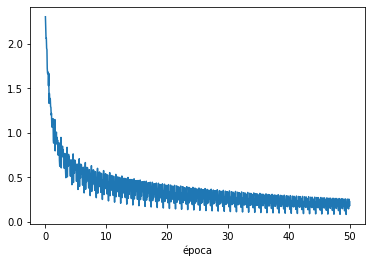

In [45]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

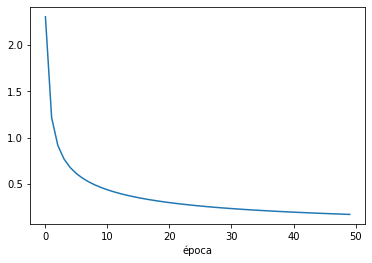

In [46]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [47]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

In [59]:
from torchvision.transforms import functional

In [48]:
# Escreva o código aqui:
x = []
y = []
y_preds = []

for x_train, y_train in loader_train:
    inputs = x_train.view(-1, 28 * 28)
    y_pred = model(inputs)
    x.append(x_train)
    y.append(y_train)
    y_preds.append(y_pred)

x = torch.cat(x, 0)
y = torch.cat(y, 0)
y_preds = torch.cat(y_preds, 0)

x_correct = x[y == y_preds.argmax(1)]
y_correct = y[y == y_preds.argmax(1)]
y_preds_correct = y_preds[y == y_preds.argmax(1)]

x_wrong = x[y != y_preds.argmax(1)]
y_wrong = y[y != y_preds.argmax(1)]
y_preds_wrong = y_preds[y != y_preds.argmax(1)]

idx_high_prob_correct = y_preds_correct.max(1).values.argmax()
idx_lowest_prob_correct = y_preds_correct.max(1).values.argmin()

idx_high_prob_wrong = y_preds_wrong.max(1).values.argmax()
idx_lowest_prob_wrong = y_preds_wrong.max(1).values.argmin()

Class: 2
Probabilidade: 14.52265453338623


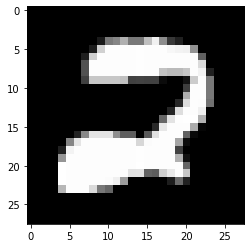

In [69]:
# Qual é a amostra classificada corretamente, com maior probabilidade?
plt.imshow(functional.to_pil_image(x_correct[idx_high_prob_correct]), cmap='gray')
print(f'Class: {y_preds_correct[idx_high_prob_correct].argmax().item()}')
print(f'Probabilidade: {y_preds_correct[idx_high_prob_correct].max().item()}')

Class wrong: 5
Probabilidade: 6.9399847984313965


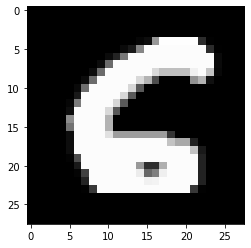

In [64]:
# Qual é a amostra classificada erradamente, com maior probabilidade?
plt.imshow(functional.to_pil_image(x_wrong[idx_high_prob_wrong]), cmap='gray')
print(f'Class wrong: {y_preds_wrong[idx_high_prob_wrong].argmax().item()}')
print(f'Probabilidade: {y_preds_wrong[idx_high_prob_wrong].max().item()}')

class: 8
probabilidade: 2.2115871906280518


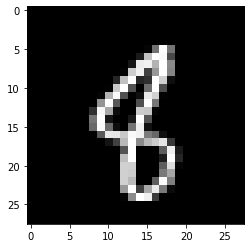

In [65]:
# Qual é a amostra classificada corretamente, com menor probabilidade?
plt.imshow(functional.to_pil_image(x_correct[idx_lowest_prob_correct]), cmap='gray')
print(f'class: {y_preds_correct[idx_lowest_prob_correct].argmax().item()}')
print(f'probabilidade: {y_preds_correct[idx_lowest_prob_correct].max().item()}')

class: 8
probabilidade 1.7878608703613281


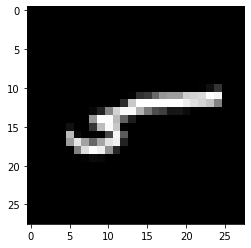

In [66]:
# Qual é a amostra classificada erradamente, com menor probabilidade?
plt.imshow(functional.to_pil_image(x_wrong[idx_lowest_prob_wrong]), cmap='gray')
print(f'class: {y_preds_wrong[idx_lowest_prob_wrong].argmax().item()}')
print(f'probabilidade {y_preds_wrong[idx_lowest_prob_wrong].max().item()}')

## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.
